# 📈 **GRAPHS ALGORITHMS GENERATOR** 

---------------------------
### **IMPORTS**

In [1]:
from sklearn.datasets import load_iris, load_digits, load_wine, load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.linear_model import LinearRegression
import numpy as np
import numbers
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
import csv
from itertools import cycle
import time
import os
import sys

src_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(src_path)
from classifiers.CoForestClassifier import CoForest
from classifiers.TriTrainingClassifier import TriTraining
from notebooks.graphs_utils import *

### **CLASS**

Fit method needs to be overwritten since graphs are generated, so inheritance is used.

In [2]:
class CoForest_graphs(CoForest):

    def fit(self, L, y, U, X_test, y_test):
        """
        Fits the ensemble using both labeled and
        pseudo-labeled data. Generates graphs to show 
        how score evolves during training.

        Parameters
        ----------
        L: np.array
            Labeled data used for training
        y: np.array
            Tags of the labeled data used for training
        U: np.array
            Unlabeled data used for training
        X_test: np.array
            samples to check evolution
        y_test: np.array
            labels of samples to check evolution
        """

        mask_L = self.create_trees(L, y)
        scores = [self.score(X_test, y_test)]

        e = [0 for i in range(self.n)]
        W = [0 for i in range(self.n)]

        previous_e = [0.5 for i in range(self.n)]
        previous_W = [min(0.1*len(L), 100) for i in range(self.n)]

        new_data = True
        t = 0

        while new_data:

            t += 1
            tree_changes = np.array([False for i in range(self.n)])
            tree_pseudo_updates = [() for i in range(self.n)]

            for i, hi in self.ensemble.items():

                e[i] = self.concomitant_oob_error(hi, L, y, mask_L)
                W[i] = previous_W[i]
                pseudo_labeled_data = []
                pseudo_labeled_tags = []

                if e[i] < previous_e[i]:

                    if e[i] == 0:
                        Wmax = self.theta * U.shape[0]
                    else:
                        Wmax = min(self.theta * U.shape[0], ((previous_e[i]*previous_W[i])/e[i]) )

                    U_subsampled = self.subsample(hi, U, Wmax) 
                    W[i] = 0

                    for u in U_subsampled:
                        concomitant_confidence, selected_class = self.concomitant_confidence(hi, U[u, :])

                        if concomitant_confidence > self.theta:
                            tree_changes[i] = True
                            pseudo_labeled_data.append(U[u, :])
                            pseudo_labeled_tags.append(selected_class)
                            W[i] += concomitant_confidence

                tree_pseudo_updates[i] = ( (np.array(pseudo_labeled_data), np.array(pseudo_labeled_tags) ) )

            for i in np.fromiter(self.ensemble.keys(), dtype=int)[tree_changes]:
                if e[i] * W[i] < previous_e[i] * previous_W[i]:
                    self.retrain_tree(i, L, y, tree_pseudo_updates[i][0], tree_pseudo_updates[i][1], mask_L)

            previous_e = deepcopy(e)
            previous_W = deepcopy(W)

            if tree_changes.sum() == 0:
                new_data = False

            scores.append(self.score(X_test, y_test))

        append_to_csv("file.csv", scores)

# **GRAPHS & COMPARES**

### **Contra KEEL** 🍣

In [3]:
l = []
for i in range(1, 11):

    # 10
    # file_train = "wine/wine-ssl10-10-{}tra.csv".format(i)
    # file_test = "wine/wine-ssl10-10-{}tst.csv".format(i)

    # 5
    file_train = "iris/{}f_tra.csv".format(i)
    file_test = "iris/{}f_tst.csv".format(i)

    L, L_tags, U = extract_training_data(file_train)
    X_test, y_test = extract_test_data(file_test)

    co_forest = CoForest(6, 0.75, max_features='log2', random_state = np.random.RandomState(5))
    co_forest.fit(L, L_tags, U)
    l.append(co_forest.score(X_test, y_test))

print(l)
print(np.array(l).mean())

[0.9333333333333333, 0.8571428571428571, 1.0, 1.0, 0.8666666666666667, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333]
0.9323809523809524


### **Variación Score - Número Iteraciones**

KeyboardInterrupt: 

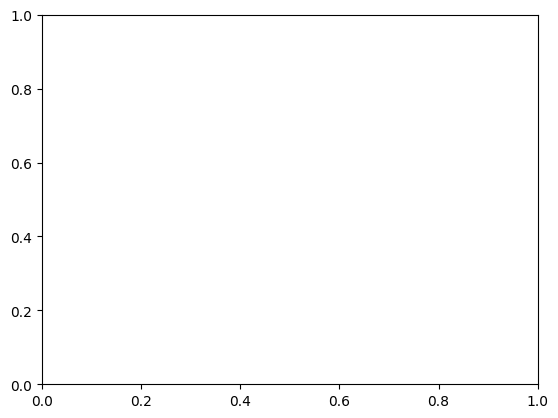

In [4]:
fig, ax = plt.subplots()
cycol = cycle('bgrcmk')
next(cycol)
available = [(load_iris(), 'Iris'), (load_digits(), 'Dígitos'), (load_wine(), 'Vino'), (load_breast_cancer(), 'Cáncer de mama')]

for dataset_info in available:

    dataset = dataset_info[0]
    available_classes = np.unique(dataset.target)
    open('file.csv', 'w').close()

    X = np.array(dataset.data)
    y = np.array(dataset.target)

    rd = np.random.RandomState(5)
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rd)

    for train_index, test_index in skf.split(X, y):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        L_train, U_train, Ly_train, Uy_train = train_test_split(X_train, y_train, test_size=0.8, random_state=rd, stratify=y_train)
        
        co_forest = CoForest_graphs(20, 0.75, 'log2', rd)
        co_forest.fit(L_train, Ly_train, U_train, X_test, y_test)

    mean = np.mean(create_graph_matrix("file.csv"), axis=0)
    ax.plot(np.arange(len(mean)), mean, '-o', color = next(cycol), label = dataset_info[1])

#plt.title("Score - Iteraciones")
ax.set_ylabel('score')
ax.set_xlabel('iteraciones')
plt.legend(loc="lower right")
plt.show()

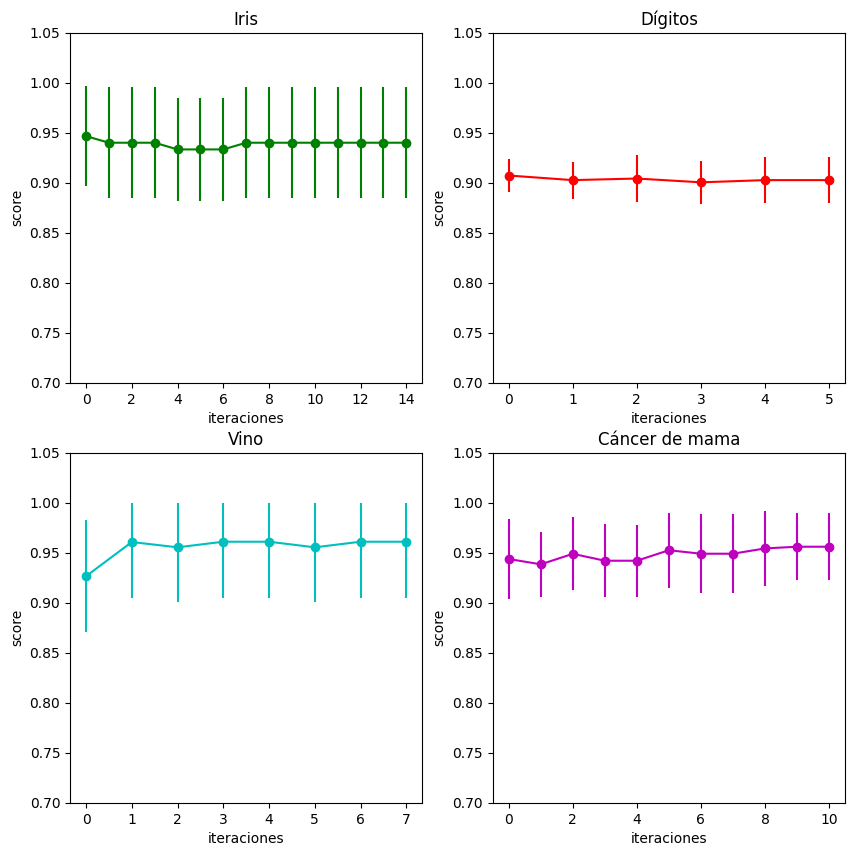

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
cycol = cycle('bgrcmk')
next(cycol)
available = [(load_iris(), 'Iris', (0,0)), (load_digits(), 'Dígitos', (0,1)), (load_wine(), 'Vino', (1,0)), (load_breast_cancer(), 'Cáncer de mama', (1,1))]

for dataset_info in available:

    open('file.csv', 'w').close()
    dataset = dataset_info[0]

    X = np.array(dataset.data)
    y = np.array(dataset.target)

    rd = np.random.RandomState(5)
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rd)

    for train_index, test_index in skf.split(X, y):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        L_train, U_train, Ly_train, Uy_train = train_test_split(X_train, y_train, test_size=0.8, random_state=rd, stratify=y_train)
        
        co_forest = CoForest_graphs(20, 0.75, 'log2', rd)
        co_forest.fit(L_train, Ly_train, U_train, X_test, y_test)

    mean = np.mean(create_graph_matrix("file.csv"), axis=0)
    std = np.std(create_graph_matrix("file.csv"), axis=0)

    coordinates = dataset_info[2]
    ax_i = ax[coordinates[0], coordinates[1]]
    ax_i.set_ylim([0.7, 1.05])
    ax_i.errorbar(np.arange(len(mean)), mean, yerr=[std, np.minimum(std, 1-mean)], fmt='-o', color = next(cycol), label = dataset_info[1])
    ax_i.set_ylabel('score')
    ax_i.set_xlabel('iteraciones')
    ax_i.set_title(dataset_info[1])
    
plt.show()

### **Número elementos - tiempo entrenamiento**


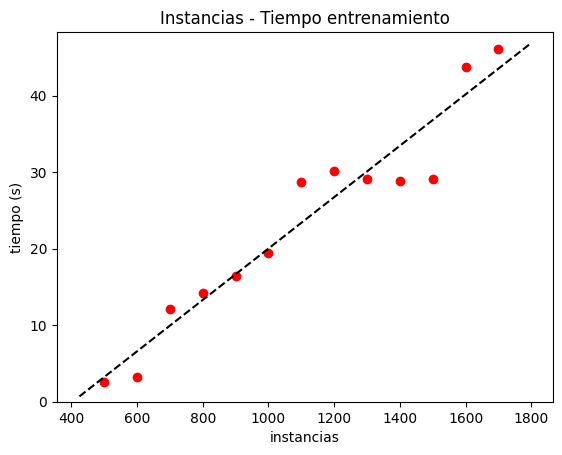

In [ ]:
cycol = cycle('bgrcmk')
fig, ax = plt.subplots()
cycol = cycle('bgrcmk')
next(cycol)
next(cycol) 

dataset_info = (load_digits(), 'Dígitos')
dataset = dataset_info[0]

instancias = []
tiempos = []
rd = np.random.RandomState(10)

for i in range(500, dataset.data.shape[0], 100):

    indexes = rd.choice(dataset.data.shape[0], replace = True, size=i)

    X = np.array(dataset.data)[indexes]
    y = np.array(dataset.target)[indexes]
    
    L_train, U_train, Ly_train, Uy_train = train_test_split(X, y, test_size=0.8, random_state=rd)

    co_forest = CoForest(20, 0.75, 'log2', rd)
    inicio = time.time()
    co_forest.fit(L_train, Ly_train, U_train)
    fin = time.time()

    instancias.append(X.shape[0])
    tiempos.append((fin-inicio))

ax.scatter(instancias, tiempos, color=next(cycol) )

model = LinearRegression()
model.fit(np.array([[i] for i in instancias]), tiempos)
x_new = np.linspace(425, dataset.data.shape[0], 100)
y_new = model.predict(x_new[:, np.newaxis])

plt.title("Instancias - Tiempo entrenamiento")
ax.set_ylim(bottom = 0)
ax.plot(x_new, y_new, '--k')
ax.set_xlabel('instancias')
ax.set_ylabel('tiempo (s)')
plt.show()

### **Score - % Instancias entrenamiento**

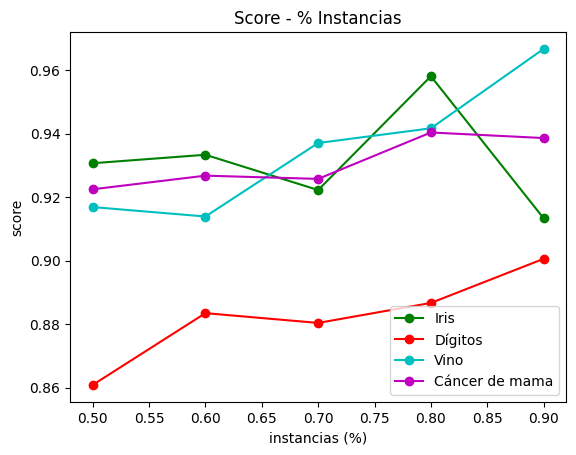

In [ ]:
fig, ax = plt.subplots()
cycol = cycle('bgrcmk')
next(cycol)
rd = np.random.RandomState(5)
available = [(load_iris(), 'Iris'), (load_digits(), 'Dígitos'), (load_wine(), 'Vino'), (load_breast_cancer(), 'Cáncer de mama')]

for dataset_info in available:

    matriz_scores = []
    dataset = dataset_info[0]
    
    for j in range(10): #Número de experimentos
        
        scores_experimento = []

        for i in np.arange(0.5, 1, 0.1):

            X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, train_size=i, random_state=rd, stratify=dataset.target)
            L_train, U_train, Ly_train, Uy_train = train_test_split(X_train, y_train, test_size=0.8, random_state=rd, stratify=y_train)
            co_forest = CoForest(20, 0.75, 'log2', rd)
            co_forest.fit(L_train, Ly_train, U_train)
            scores_experimento.append(co_forest.score(X_test, y_test))

        matriz_scores.append(scores_experimento)

    ax.plot(np.arange(0.5, 1, 0.1), np.mean(np.array(matriz_scores), axis=0), '-o', color=next(cycol),  label=dataset_info[1])

plt.title("Score - % Instancias")
ax.set_ylabel('score')
ax.set_xlabel('instancias (%)')
plt.legend(loc="lower right")
plt.show()

### **Score / nº árboles**

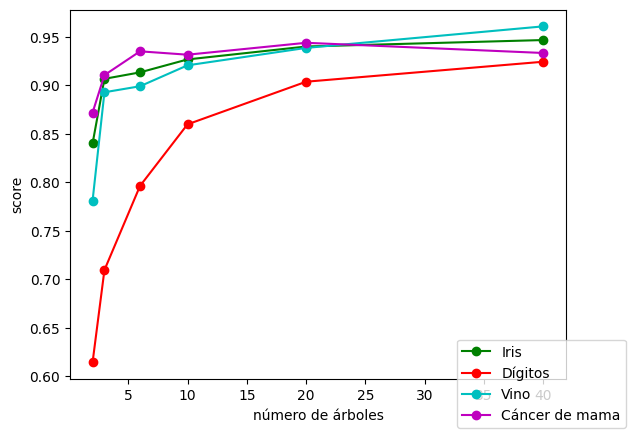

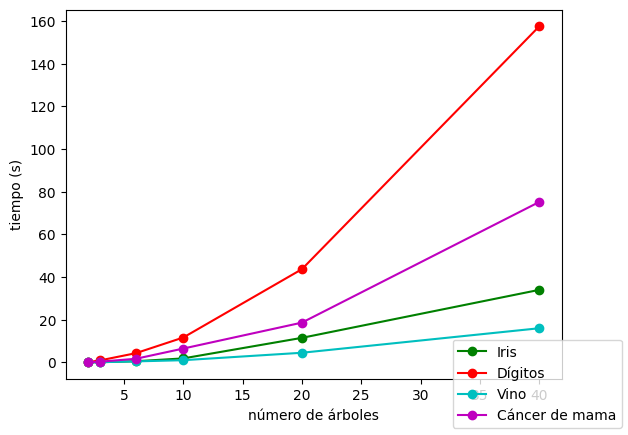

In [ ]:
fig, ax = plt.subplots()
fig_2, ax_2 = plt.subplots()

cycol = cycle('bgrcmk')
next(cycol)
available = [(load_iris(), 'Iris'), (load_digits(), 'Dígitos'), (load_wine(), 'Vino'), (load_breast_cancer(), 'Cáncer de mama')]

for dataset_info in available:

    dataset = dataset_info[0]
    available_classes = np.unique(dataset.target)

    X = np.array(dataset.data)
    y = np.array(dataset.target)

    rd = np.random.RandomState(5)
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rd)

    matriz_scores = []
    matriz_tiempos = []

    for train_index, test_index in skf.split(X, y):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        L_train, U_train, Ly_train, Uy_train = train_test_split(X_train, y_train, test_size=0.8, random_state=rd, stratify=y_train)
        scores_fold = []
        times_fold = []
        
        for j in [2, 3, 6, 10, 20, 40]:
            co_forest = CoForest(j, 0.75, 'log2', rd)
            inicio = time.time()
            co_forest.fit(L_train, Ly_train, U_train)
            fin = time.time()
            times_fold.append((fin-inicio))
            scores_fold.append(co_forest.score(X_test, y_test))

        matriz_scores.append(scores_fold)
        matriz_tiempos.append(times_fold)

    c = next(cycol)
    ax.plot(np.array([2, 3, 6, 10, 20, 40]), np.mean(np.array(matriz_scores), axis=0), '-o', color=c,  label=dataset_info[1])
    ax_2.plot(np.array([2, 3, 6, 10, 20, 40]), np.mean(np.array(matriz_tiempos), axis=0), '-o', color=c,  label=dataset_info[1])

#plt.title("Score - Número de árboles")
ax.set_ylabel('score')
ax.set_xlabel('número de árboles')
fig.legend(loc="lower right")

ax_2.set_ylabel('tiempo (s)')
ax_2.set_xlabel('número de árboles')
fig_2.legend(loc="lower right")

plt.show()